## Machine Learning Project: Crime prediction in Chicago
#### The problem we propose is to predict future occurrences of crime by identifying times and locations for different crime types for Chicago. 

### Import Chicago crime location dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [2]:
inputfile = 'Crimes_-_2008_to_present.csv' ## Full crime dataset from 2008

In [5]:
columns_to_use = ['Date', 'District', 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Community Area'] ## The GPS coordinates seem to be suited enough

data = pd.read_csv(inputfile, sep=',', encoding='utf8', usecols=columns_to_use)
data = data[np.isfinite(data['District'])]
data.columns

Index(['Date', 'District', 'Community Area', 'X Coordinate', 'Y Coordinate',
       'Latitude', 'Longitude'],
      dtype='object')

In [6]:
data.head()

,Date,District,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude
0,08/15/2016 04:10:55 PM,11.0,26.0,NaN,NaN,NaN,NaN
1,08/19/2016 08:14:00 PM,11.0,26.0,NaN,NaN,NaN,NaN
2,07/29/2016 01:46:00 PM,7.0,67.0,NaN,NaN,NaN,NaN
3,01/04/2017 12:26:00 AM,25.0,25.0,NaN,NaN,NaN,NaN
4,01/04/2017 12:15:00 AM,4.0,46.0,NaN,NaN,NaN,NaN


### Visualizations
#### Let's present here some manipulations that allow to visualise crimes GPS coordinates. First, we scatter the whole dataset, and then its districts repartition. Next we create geographical clusters that will replace districts. These clusters will form new location features in order to predict crimes through them. 

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.5)

cordX = data['X Coordinate'].as_matrix()
cordX = cordX[~np.isnan(cordX)]
cordY = data['Y Coordinate'].as_matrix()
cordY = cordY[~np.isnan(cordY)]
cordX = [a for a in cordX if (a >= 1000)]
cordY = [a for a in cordY if (a >= 1000)]

plt.title("Crime positions in Chicago", fontsize = 15)
plt.scatter(cordX, cordY)

[13 10 10 ...,  4 15  0]


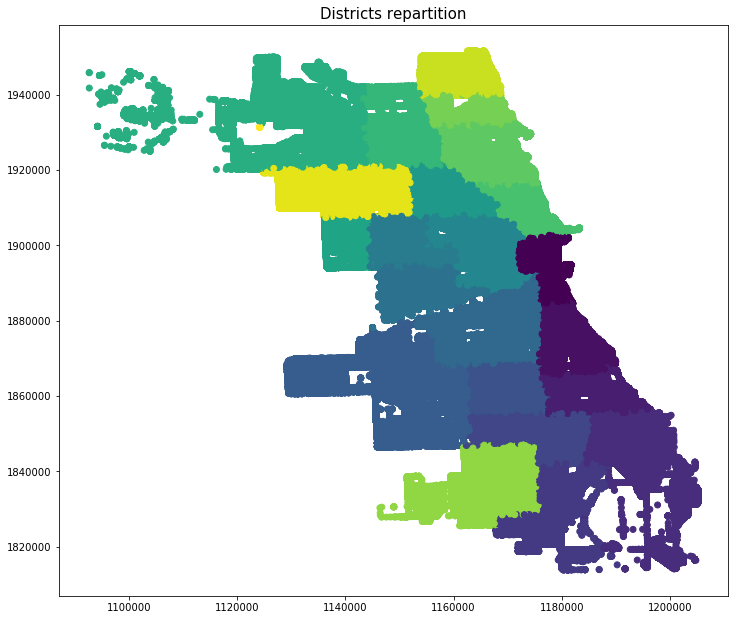

In [7]:
from sklearn import preprocessing
import matplotlib.patches as mpatches

cordX = data['X Coordinate'].as_matrix()
cordY = data['Y Coordinate'].as_matrix()

labels = preprocessing.LabelEncoder()
district = data['District'].as_matrix()
labels.fit(district)
districts_labeled = labels.transform(district) 
print(districts_labeled)
mask = np.isnan(data['X Coordinate'].as_matrix())
cordX = cordX[~mask]
cordY = cordY[~mask]
districts_labeled = districts_labeled[~mask]

""" dirty way to eliminate nonsense points """
mask2 = []
for i in range(len(cordX)): 
    if cordX[i] < 1000 or cordY[i] < 1000:
        mask2.append(i)
        
cordX = np.delete(cordX, mask2)
cordY = np.delete(cordY, mask2)
districts_labeled = np.delete(districts_labeled, mask2)

plt.title("Districts repartition", fontsize = 15)
plt.scatter(cordX, cordY, c=districts_labeled)

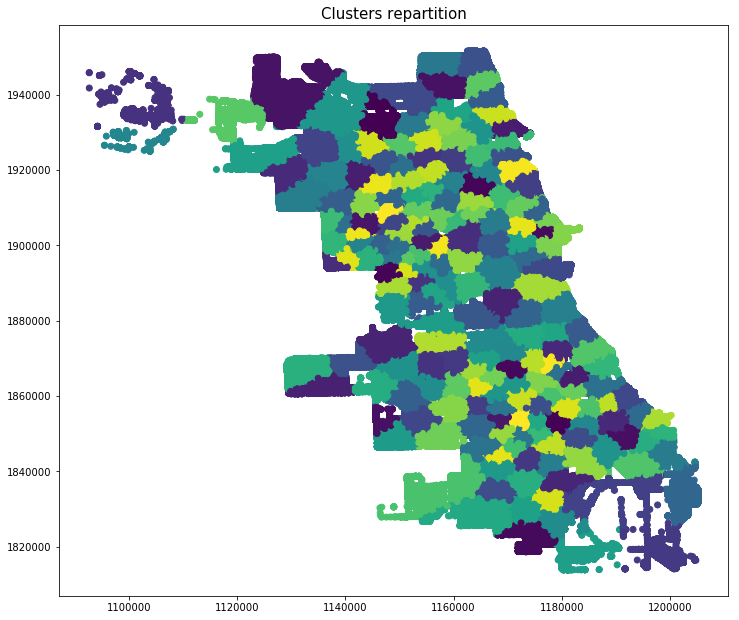

In [6]:
from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.cluster import *

data = data.dropna()

coordX = data['X Coordinate']
coordY = data['Y Coordinate']
coordXY = pd.concat([coordX, coordY],axis=1).as_matrix()

modelCluster = MiniBatchKMeans(n_clusters=200, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True,
                                 random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)

listClusters = modelCluster.fit_predict(coordXY)

coordX = coordX.as_matrix()
coordY = coordY.as_matrix()

""" dirty way to eliminate nonsense points """
mask2 = []
for i in range(len(coordX)):
    if coordX[i] < 1000 or coordY[i] < 1000:
        mask2.append(i)
        
coordX = np.delete(coordX, mask2)
coordY = np.delete(coordY, mask2)
listClusters = np.delete(listClusters, mask2)

plt.title("Clusters repartition", fontsize = 15)
plt.scatter(coordX, coordY, c=listClusters)

### Assign hardship index to newly created clusters

In [7]:
# Recreate clusters based on latitude and longitude

from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.cluster import *

data = data.dropna()

coordX = data['Longitude']
coordY = data['Latitude']
coordXY = pd.concat([coordX, coordY],axis=1).as_matrix()

modelCluster = MiniBatchKMeans(n_clusters=50, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True,
                                 random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)

listClusters = modelCluster.fit_predict(coordXY)

coordX = coordX.as_matrix()
coordY = coordY.as_matrix()

#plt.title("Clusters repartition", fontsize = 15)
#plt.scatter(coordX, coordY, c=listClusters)

In [23]:
# Since the Community Area lat-lon comes from the center of the Area, we will also select the center of each cluster
# From the cluster center, we will find the distance from each center of the Community Area identified
# We select the minimum distance to assign the Community Area and corresponding Hardship Index
ClustCenters = pd.DataFrame(modelCluster.cluster_centers_) 
ClustCenters['Cluster_nbr'] = Centers.index
ClustCenters.columns = ['Center_lon', 'Center_lat', 'Cluster_nbr']
ClustCenters.tail()


,Center_lon,Center_lat,Cluster_nbr
45,-87.711814,41.974138,45
46,-87.657829,41.730233,46
47,-87.621125,41.825945,47
48,-87.568202,41.742293,48
49,-87.673303,41.851805,49


In [24]:
# Hardship Index information

xtrafile = 'chi_se_2008_2012.csv'

xcolumns_to_use = ['Community Area Number', 'Latitude', 'Longitude', 'HARDSHIP INDEX'] 
xdata = pd.read_csv(xtrafile, sep=',', encoding='utf8', usecols=xcolumns_to_use)
xdata.columns = ['CAN', 'CA_lat', 'CA_lon', 'HI']

xdata.columns

Index(['CAN', 'CA_lat', 'CA_lon', 'HI'], dtype='object')

In [25]:
xdata.head()

,CAN,CA_lat,CA_lon,HI
0,1,42.010529,-87.687114,39
1,2,42.001340,-87.710225,46
2,3,41.966138,-87.670147,20
3,4,41.969948,-87.693354,17
4,5,41.946919,-87.702608,6


In [26]:
# Haversine formula to compute distance between latitudes and longitudes, results in distance in kilometers

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [28]:
# Calculate distance between centers of each cluster and each community area and assign based on minimum distance

D = {}
for x in range(0,50):
    for y in range(0,77):
        d=haversine(ClustCenters.Center_lon[x], ClustCenters.Center_lat[x], xdata.CA_lon[y], xdata.CA_lat[y])
        
        if y == 0:
            D[x]= [y,d]
        elif d<D[x][1]:
            D[x]=[y,d]

In [29]:
# View assignments in dictionary
D

{0: [65, 1.6567969222725596],
 1: [25, 1.9103982508194672],
 2: [2, 1.4775166299845197],
 3: [42, 0.9031628857635152],
 4: [32, 1.101259913561289],
 5: [52, 2.202233982366179],
 6: [6, 1.8001327910929898],
 7: [68, 0.9365505092569515],
 8: [27, 1.1410971966945813],
 9: [75, 2.4085715138158346],
 10: [13, 1.7264675685979554],
 11: [7, 1.5902054367442167],
 12: [47, 0.6663770937204037],
 13: [70, 1.6633223138456967],
 14: [29, 0.23837687783474196],
 15: [18, 1.3770991066751244],
 16: [69, 1.1252091710961398],
 17: [20, 1.7747663903250617],
 18: [60, 0.9433735603824306],
 19: [69, 1.516294981864941],
 20: [53, 0.6823665410602944],
 21: [0, 0.9281021742399603],
 22: [74, 0.639202683160458],
 23: [61, 0.8880087559932459],
 24: [45, 1.8427798795315389],
 25: [51, 1.5502213918158623],
 26: [44, 0.4436786269866212],
 27: [36, 1.8603634915399578],
 28: [25, 0.7072392694787186],
 29: [49, 0.22261009998737458],
 30: [2, 2.9279755941312047],
 31: [7, 1.6379025213771345],
 32: [38, 0.39579771666482

In [31]:
# Add hardship index to cluster, community area in dataframe
clustdf = pd.DataFrame(np.arange(0,50))
clustdf.columns = ['Cluster_nbr']
clustdf['CAN']= clustdf['Cluster_nbr'].apply(lambda x: D[x][0])
clustdf = clustdf.merge(xdata, on = ['CAN'], how = 'left')
clustdf = clustdf.drop(['CA_lat', 'CA_lon'], axis=1)
clustdf.head()

,Cluster_nbr,CAN,HI
0,0,65,56.0
1,1,25,73.0
2,2,2,46.0
3,3,42,58.0
4,4,32,3.0


In [ ]:
# Save assignments to csv
# clustdf.to_csv('C:/Users/amu277/Documents/hardship_index_cluster.csv')